In [44]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

TEMPERATURE = 298*kelvin
FRICTION = 1/picosecond
TIMESTEP = 2*femtoseconds

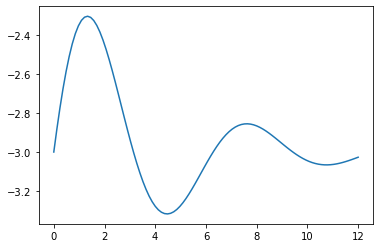

In [25]:
import numpy as np
import matplotlib.pyplot as plt

xa = np.linspace(0, 12, 100)
ya = np.sin(xa)*np.exp(-xa/4)-3

plt.plot(xa, ya)

In [49]:
k = 0.5
E = -2.8

def boost(x, E, k):
    return (x + 0.5*k*(E-x )**2)/x


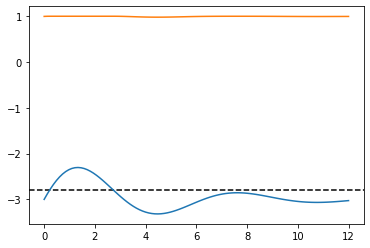

In [53]:
k = 0.5
E = -2.8
plt.axhline(E,c='k',linestyle='--')

plt.plot(xa,ya)
plt.plot(xa, np.where(ya<E, boost(ya, E, k), 1))

In [58]:
k = 0.5
E = -2.8

def boost(x, E, k):
    return (x + 0.5*k*(E-x )**2)/x

def boostPE(x, E, k):
    return x*(x + 0.5*k*(E-x )**2)/x

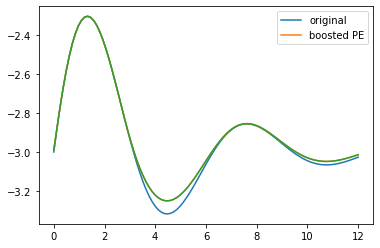

In [62]:
plt.plot(xa, ya, label='original')
plt.plot(xa, np.where(ya<E, boostPE(ya, E, k), ya), label='boosted PE')

plt.plot(xa, ya*np.where(ya<E, boost(ya, E, k), 1))

plt.legend()

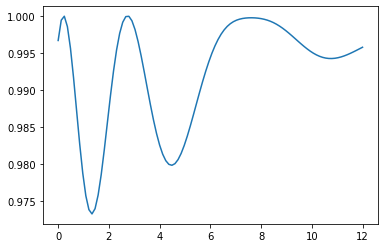

In [63]:
plt.plot(xa, boost(ya, E, k))

# Generate a small waterbox:

In [64]:
f = open('tip3p-1.pdb', 'w')
s = """REMARK   1 CREATED WITH OPENMM 7.1.1, 2018-04-06
CRYST1   24.668   24.668   24.668  90.00  90.00  90.00 P 1           1 
HETATM    1  O   HOH A   1      20.854   7.945   2.695  1.00  0.00           O  
HETATM    2  H1  HOH A   1      20.168   7.772   3.339  1.00  0.00           H  
HETATM    3  H2  HOH A   1      21.142   8.838   2.885  1.00  0.00           H  
END
"""
f.write(s)
f.close()

In [65]:
pdb = PDBFile('tip3p-1.pdb')
omm_forcefield= ForceField('amber14/tip3pfb.xml')
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addSolvent(omm_forcefield, ionicStrength=0.15*molar)
PDBFile.writeFile(modeller.topology, modeller.positions, file=open('solvated.pdb', 'w'))

sod = [i.index for i in modeller.topology.atoms() if i.residue.name=='NA'][0]
cla = [i.index for i in modeller.topology.atoms() if i.residue.name=='CL'][0]

In [66]:
system = omm_forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
         nonbondedCutoff=0.9*nanometer, constraints=HBonds)



integrator = LangevinIntegrator(TEMPERATURE, FRICTION, TIMESTEP)
platform = Platform.getPlatformByName('OpenCL')
prop = {'OpenCLPrecision':'single'}

simulation = Simulation(modeller.topology, system, integrator, platform, prop)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()


# Equilibrate the box size, and take some statistics on PE

In [67]:
cmd_pe = list()
distances = list()
for i in tqdm.tqdm_notebook(range(5000)):
    simulation.step(50)
    state = simulation.context.getState(getEnergy=True)
    nrg = state.getPotentialEnergy()
    cmd_pe.append(nrg)

In [68]:
# save this state so we can return to it:
saved_state = simulation.context.getState(getPositions=True, getVelocities=True)

In [69]:
#cut off first 100 samples as equilibration
pe = np.array([i/kilojoule*mole for i in cmd_pe[50:]])


# Define a GaMDLangevinIntegrator:

In [82]:
class CustomGaMDLangevinIntegrator(CustomIntegrator):
    def __init__(self, temperature, friction, dt, k, E):
        self.k = k 
        self.E = E #threshold value
        
        CustomIntegrator.__init__(self, dt)
            #lew added:
        self.addGlobalVariable("k", k)
        self.addGlobalVariable("E", E)
            #normal langevin:  
        self.addGlobalVariable("temperature", temperature);
        self.addGlobalVariable("friction", friction);
        self.addGlobalVariable("vscale", 0);
        self.addGlobalVariable("fscale", 0);
        self.addGlobalVariable("noisescale", 0);
        self.addPerDofVariable("x0", 0);
            #normal langevin:                                                                  
        self.addUpdateContextState();
        self.addComputeGlobal("vscale", "exp(-dt*friction)");
        self.addComputeGlobal("fscale", "(1-vscale)/friction");
        #original line:                
        self.addComputeGlobal("noisescale", "sqrt(kT*(1-vscale*vscale)); kT=0.00831451*temperature");
        self.addComputePerDof("x0", "x");
            #original langevin line:                                                                                      
        #self.addComputePerDof("v", "vscale*v + fscale*f/m + noisescale*gaussian/sqrt(m)");  
            #GaMD:
        #self.addComputePerDof("v", "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);fprime=f*((1-modify) + modify*(alpha/(alpha+E-energy))^2);modify=step(E-energy)"); 
        dof_string = "vscale*v + fscale*fprime/m + noisescale*gaussian/sqrt(m);"
        dof_string+= "fprime = f*((1-modify) + modify*((energy + 0.5*k*(E-energy )^2)/energy)  );" #multiplying f by factor equivalent to what V(r) was multiplied by
        dof_string+= "modify = step(E-energy);" #'modify' will be 1 when energy is below E

        
        self.addComputePerDof("v", dof_string); 
        #self.addComputePerDof("v", "v+dt*fprime/m; fprime=f*((1-modify) + modify*(alpha/(alpha+E-energy))^2); modify=step(E-energy)")
            #normal langevin                                            
        self.addComputePerDof("x", "x+dt*v");
        self.addConstrainPositions();
        self.addComputePerDof("v", "(x-x0)/dt");
        self.addComputePerDof("veloc", "v")
        
    def getEffectiveEnergy(self, energy):
        """Given the actual potential energy of the system, return the value of the effective potential."""
        k = self.k
        E = self.E
        if not is_quantity(energy):
            energy = energy*kilojoules_per_mole # Assume kJ/mole
        if (energy > E):
            return energy
        return energy + ( 0.5 * k * (E-energy)**2 ) # 'k' parameter should instead be per kj/mol



In [118]:
sim.integrator.E

Quantity(value=-23167.975669942505, unit=kilojoule/mole)

In [120]:
sim.integrator.k

Quantity(value=0.0009964122107513325, unit=mole/kilojoule)

In [124]:
(-23167.975--23800)**2 *0.0009964122107513325*0.5

199.0112190578797

In [125]:
-23800 + (-23167.975--23800)**2 *0.0009964122107513325*0.5

-23600.98878094212

In [119]:
sim.integrator.getEffectiveEnergy(-23800)

Quantity(value=-23600.989202843168, unit=kilojoule/mole)

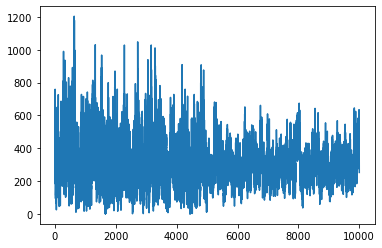

In [127]:
plt.plot((p_eff - p_amd))

In [83]:
CustomGaMDLangevinIntegrator

__main__.CustomGaMDLangevinIntegrator

# make a convenience function to create GaMD systems:

In [84]:
def make_GaMD_system(modeller, state, E, k):
    system = omm_forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
         nonbondedCutoff=0.9*nanometer, constraints=HBonds)

    integrator = CustomGaMDLangevinIntegrator(TEMPERATURE, 
                                             FRICTION, 
                                             TIMESTEP, 
                                             k=float(k)/kilojoules_per_mole,
                                             E=float(E)*kilojoules_per_mole)
    platform = Platform.getPlatformByName('OpenCL')
    prop = {'OpenCLPrecision':'single'}

    simulation = Simulation(modeller.topology, system, integrator, platform, prop)
    simulation.context.setPositions(state.getPositions())
    simulation.context.setVelocities(state.getVelocities())
    simulation.context.setPeriodicBoxVectors(*saved_state.getPeriodicBoxVectors())
    
    return simulation

# Set some initial parameters after the cMD run:

We will set the boost potential in the "minimum" option, which means equivalent to `Vmax`

In [85]:
#set the desired maximum standard deviation of the boost potential to be 10kT: 
sigma_0 = (MOLAR_GAS_CONSTANT_R * TEMPERATURE ).value_in_unit(kilojoule_per_mole) * 10
print(f'Sigma0: {sigma_0}')

#potential energy statistics:
Vmax = pe.max()
Vmin = pe.min()
Vavg = pe.mean()
Vstd = np.std(pe)

print(f'Vmax: {Vmax},\nVmin: {Vmin},\nVavg: {Vavg},\nVstd: {Vstd}')

Sigma0: 24.777127964236243
Vmax: -23525.641917518504,
Vmin: -24621.235667518507,
Vavg: -24060.90221423568,
Vstd: 142.6586235916714


Determining the k parameter based on prof Miaos rules:

In [86]:
k_0 = min(1, sigma_0/Vstd * ((Vmax-Vmin)/(Vmax-Vavg)))

k = k_0 * (1 / (Vmax - Vmin) )

print(f'k_0: {k_0},\nk: {k}')

k_0: 0.355498235824903,
k: 0.0003244799779342496


In [128]:

sim = make_GaMD_system(modeller, saved_state, Vmax, k)

#this will store the effective PE (i.e. the REAL potential energy felt by the system)
pe_effective = list()

#this will store the naively calculated PE (i.e. the potential without the boost)
pe_unboosted = list()

#this will store the values of k as we iteratively improve it:
ks = list()
          

for _ in range(20):
    
    #_pe = list()
    #_pe_eff = list()

    #equilibrate:
    sim.step(10000)
    for i in tqdm.tqdm_notebook(range(2500)):
        sim.step(50)
        state = sim.context.getState(getEnergy=True)
        nrg = state.getPotentialEnergy()

        eff_nrg = sim.integrator.getEffectiveEnergy(nrg)
        pe_unboosted.append(nrg)
        pe_effective.append(eff_nrg)
        
    p_amd = np.array([i/kilojoule*mole for i in pe_unboosted]) #this is the naive PE
    p_eff = np.array([i/kilojoule*mole for i in pe_effective]) #this is the actually experienced PE
    
    _vmax = p_eff.max() #maximum of actually exp. PE
    _vmin = p_eff.min() #Minimum
    _vavg = p_eff.mean() #average
    _std = np.std(p_eff) #standard dev.
    
    k_0 = min(1,(sigma_0/_std ) * ((_vmax-_vmin)/(_vmax-_vavg)))
    k = k_0 * (1 / (_vmax - _vmin) )

    state = sim.context.getState(getPositions=True, getVelocities=True)

    ks.append(k)
    
    print(_vmax, k)
    
    sim = make_GaMD_system(modeller, state, _vmax, k)
    
    #pe_effective.append(p_eff)
    #pe_unboosted.append(p_amd)
    


-23560.046695004858 0.0010023099985071897



-23515.391917518504 0.0008507278138714497



-23502.063792518504 0.0008022090026317437



-23502.063792518504 0.0007773171184244439



-23502.063792518504 0.0007699536978392613



-23502.063792518504 0.0007400641103362501



-23502.063792518504 0.0007271582087119579



-23502.063792518504 0.0007202142697840065



-23502.063792518504 0.0007135493003974885



-23457.915355018504 0.0006375065494295402



-23457.915355018504 0.0006358477550457755



-23457.915355018504 0.0006304559523520765



-23457.915355018504 0.0006224667861135263



-23457.915355018504 0.0006211044464265311



-23457.915355018504 0.0006189785074166465



-23457.915355018504 0.0006184517844615362



-23457.915355018504 0.0006192095632935882



-23457.915355018504 0.0006205563161204227



-23457.915355018504 0.0006160778985784759



-23457.915355018504 0.0006141561863482416


# Assess convergence of estimated parameters k and E

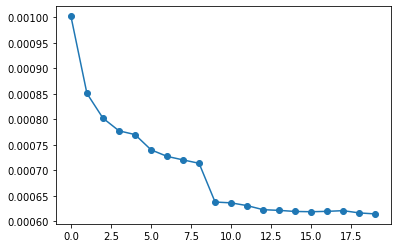

In [129]:
plt.plot(ks, '-o')

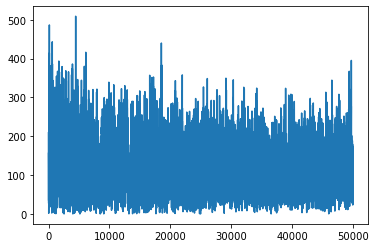

In [134]:
plt.plot(p_eff-p_amd)

<AxesSubplot:>

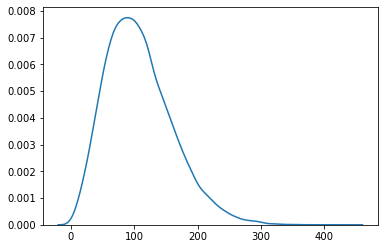

In [137]:
kdeplot((p_eff-p_amd)[10000:])

In [ ]:
plt.hist((p_eff-p_amd)[10000:])

`E` parameter has not stabilized. Do some more iterations:

In [31]:
for _ in range(20):
    
    _pe = list()
    _pe_eff = list()

    for i in tqdm.tqdm_notebook(range(500)):
        sim.step(50)
        state = sim.context.getState(getEnergy=True)
        nrg = state.getPotentialEnergy()

        eff_nrg = sim.integrator.getEffectiveEnergy(nrg)
        _pe.append(nrg)
        _pe_eff.append(eff_nrg)
        
    p_amd = np.array([i/kilojoule*mole for i in _pe]) #this is the naive PE
    p_eff = np.array([i/kilojoule*mole for i in _pe_eff]) #this is the actually experienced PE
    
    _vmax = p_eff.max() #maximum of actually exp. PE
    _vmin = p_eff.min() #Minimum
    _vavg = p_eff.mean() #average
    _std = np.std(p_eff) #standard dev.
    
    k_0 = min(1,(sigma_0/_std ) * ((_vmax-_vmin)/(_vmax-_vavg)))
    k = k_0 * (1 / (_vmax - _vmin) )

    state = sim.context.getState(getPositions=True, getVelocities=True)

    ks.append(k)
    
    print(_vmax, k)
    
    sim = make_GaMD_system(modeller, state, _vmax, k)
    
    pe_effective.append(p_eff)
    pe_unboosted.append(p_amd)


-20910.712230018504 0.0005798682491973984



-20798.884105018504 0.0005096359014623196



-20825.282227451742 0.0006565859231721314



-20713.610667518504 0.0005565739600817945



-20646.048167518504 0.0005464975955806664



-20474.673167518504 0.0004026184581494732



-20600.693486724376 0.000586217316395066



-20410.720042518504 0.0004149359626624501



-20594.06508121519 0.000770611151959315



-20187.923167518504 0.0003309093340678036



-20412.25802577963 0.000564499300807019



-20111.157542518504 0.00032136960197555047



-20295.811582456932 0.000518322967415191



-20334.0827317625 0.0006136049105730241



-20191.673167518504 0.00046548258343204126



-20175.782542518504 0.0004728531909254805



-20190.11644656099 0.0005207816082707229



-19992.345042518504 0.00036551505223855155



-20064.021318117557 0.0004343164667125328



-20027.923167518504 0.0004165655232776685


assess convergence again:

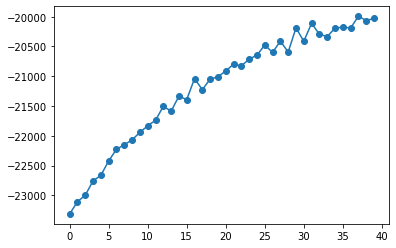

In [32]:
plt.plot([max(i) for i in pe_effective], '-o')

maybe one more run:


In [35]:
for _ in range(20):
    
    _pe = list()
    _pe_eff = list()

    for i in tqdm.tqdm_notebook(range(500)):
        sim.step(50)
        state = sim.context.getState(getEnergy=True)
        nrg = state.getPotentialEnergy()

        eff_nrg = sim.integrator.getEffectiveEnergy(nrg)
        _pe.append(nrg)
        _pe_eff.append(eff_nrg)
        
    p_amd = np.array([i/kilojoule*mole for i in _pe]) #this is the naive PE
    p_eff = np.array([i/kilojoule*mole for i in _pe_eff]) #this is the actually experienced PE
    
    _vmax = p_eff.max() #maximum of actually exp. PE
    _vmin = p_eff.min() #Minimum
    _vavg = p_eff.mean() #average
    _std = np.std(p_eff) #standard dev.
    
    k_0 = min(1,(sigma_0/_std ) * ((_vmax-_vmin)/(_vmax-_vavg)))
    k = k_0 * (1 / (_vmax - _vmin) )

    state = sim.context.getState(getPositions=True, getVelocities=True)

    ks.append(k)
    
    print(_vmax, k)
    
    sim = make_GaMD_system(modeller, state, _vmax, k)
    
    pe_effective.append(p_eff)
    pe_unboosted.append(p_amd)


-20085.954266549033 0.0004994627556367842



-19972.251292518504 0.000397097161670129



-20131.466142556117 0.0005671790010061947



-20147.056744945217 0.0006647847265365572



-19978.454417518504 0.0004466346309811627



-20097.38169808471 0.0006111236829464351



-19994.805980018504 0.00048447281288412466



-19956.868480018504 0.00046565980406776636



-20007.484059438506 0.000525387135390694



-19916.126292518504 0.00042392202455666803



-19805.055980018504 0.0003461233493780055



-20017.459172611787 0.0005542278047280617



-19995.610667518504 0.000566735644903463



-19811.743480018504 0.0003689018970464882



-19928.430233584382 0.00048302876836693706



-19833.032542518504 0.0003661740612314879



-20022.43413867941 0.0005573080886247916



-19905.212230018504 0.00042226285686053464



-19821.102855018504 0.0003650180279844213



-19909.34495042737 0.0004277887322689501


got to be converged this time:


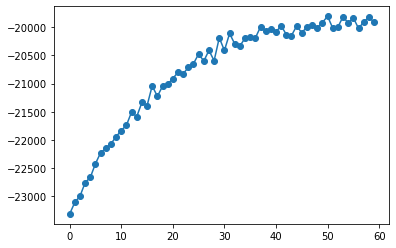

In [36]:
plt.plot([max(i) for i in pe_effective], '-o')

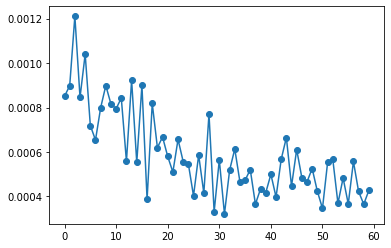

In [46]:
plt.plot(ks, '-o')

# Now the ultimate test. Is the boost Gaussian shaped?

<AxesSubplot:>

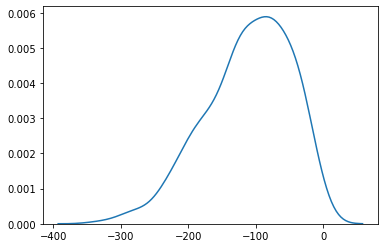

In [97]:
from seaborn import kdeplot
kdeplot(p_amd - p_eff,)

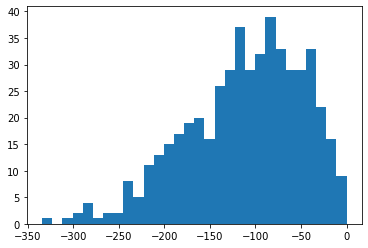

In [98]:
_=plt.hist(p_amd - p_eff, bins=30)